# WORD2VEC Embedding

## Import Statements

In [1]:
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

## Load a csv file and text files onto a Pandas Dataframe

In [2]:
year = 1924

In [3]:
df = pd.read_csv(f'{year}/metadata.csv')

In [4]:
# A fuction to load .txt files from ocr_texts directory
def read_text_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return None  # or return an appropriate response


In [5]:
# Assuming the file path is in the 'file' column
df['text'] = df['file'].apply(lambda x: read_text_file(x))

## Pre-process the text

### Improve OCR text

In [6]:
ocr_corrections = {
    # Incorrectly splited words
    'c hinese': 'chinese',
    'ch inese': 'chinese',
    'chi nese': 'chinese',
    'chin ese': 'chinese',
    'chine se': 'chinese',
    'chines e': 'chinese',
    'ja panese': 'japanese',
    'jap anese': 'japanese',
    'japa nese': 'japanese',
    'japan ese': 'japanse',
    'japane se': 'japanese',
    'for eign': 'foreign',
    'manchu ria': 'manchuria',
    'immi grant': 'immigrant',
    'immi gration': 'immigration',
    # Incorrectly spelled words
    'japanse': 'japanese',
    # Context-specific synonyms
    'nipponese': 'japanese'
}

def correct_ocr(text, corrections):
    for error, correction in corrections.items():
        text = text.replace(error, correction)
    return text

In [7]:
def preprocess_text(text):
     # Check if the text is a string
    if not isinstance(text, str):
        # Handle non-string text, e.g., by converting to string or returning a default value
        text = str(text)  # or return a default value like ''
        
    # Remove numbers and special characters from the text
    text = re.sub("[^A-Za-z]+", " ", text)
    # Turn all words into lower case
    text = text.lower()
    # Correct incorrectly split words in the above dictionary
    text = correct_ocr(text, ocr_corrections)
    return text
    
df['processed_text'] = df['text'].apply(preprocess_text)

### Tokenize the text

In [8]:
# Initialze lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))  # Convert to a set for faster membership checking

def tokenize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmetize the text
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in english_stopwords]
    return processed_tokens

df['tokenized_text'] = df['processed_text'].apply(tokenize_text)

## Train Word2Vec

In [9]:
# Hyperparameters (vector_size = 100, window = 20, min_count = 20)
model = Word2Vec(df['tokenized_text'], vector_size=100, window=20, min_count=20, workers=4)

## Analyze Results

In [10]:
model.wv.most_similar(positive=['japanese'], topn=30)

[('japan', 0.8426129817962646),
 ('jap', 0.7847336530685425),
 ('immigration', 0.7311608195304871),
 ('nippon', 0.7303518652915955),
 ('oriental', 0.6959285736083984),
 ('tokyo', 0.6942564845085144),
 ('tokio', 0.6918426156044006),
 ('boycott', 0.6878640651702881),
 ('osaka', 0.6861370801925659),
 ('toklo', 0.6822401285171509),
 ('asiatic', 0.6814981698989868),
 ('emigration', 0.6775137782096863),
 ('exclusion', 0.6751306056976318),
 ('exclude', 0.6733906269073486),
 ('immigra', 0.6368845701217651),
 ('mikado', 0.6271772384643555),
 ('japa', 0.6250975728034973),
 ('korean', 0.6215031147003174),
 ('korea', 0.6079872846603394),
 ('immigrant', 0.6075930595397949),
 ('clusion', 0.5982896089553833),
 ('hawaii', 0.5969690680503845),
 ('migration', 0.5966969132423401),
 ('nese', 0.5956566333770752),
 ('nichi', 0.5904731154441833),
 ('kobe', 0.5877259373664856),
 ('alien', 0.5868546366691589),
 ('excluding', 0.5844253897666931),
 ('orient', 0.5824679732322693),
 ('emigrant', 0.5752909779548645

In [11]:
enemy = model.wv.similarity('japanese', 'enemy')
print(enemy)

0.079421766


In [12]:
immigrant = model.wv.similarity('japanese', 'immigrant')
print(immigrant)

0.607593


In [13]:
soldier = model.wv.similarity('japanese', 'soldier')
print(soldier)

0.0046148794


In [14]:
ally = model.wv.similarity('japanese', 'ally')
print(ally)

-0.060584873


In [15]:
american = model.wv.similarity('japanese', 'american')
print(american)

0.38586763


In [16]:
chinese = model.wv.similarity('japanese', 'chinese')
print(chinese)

0.5308967


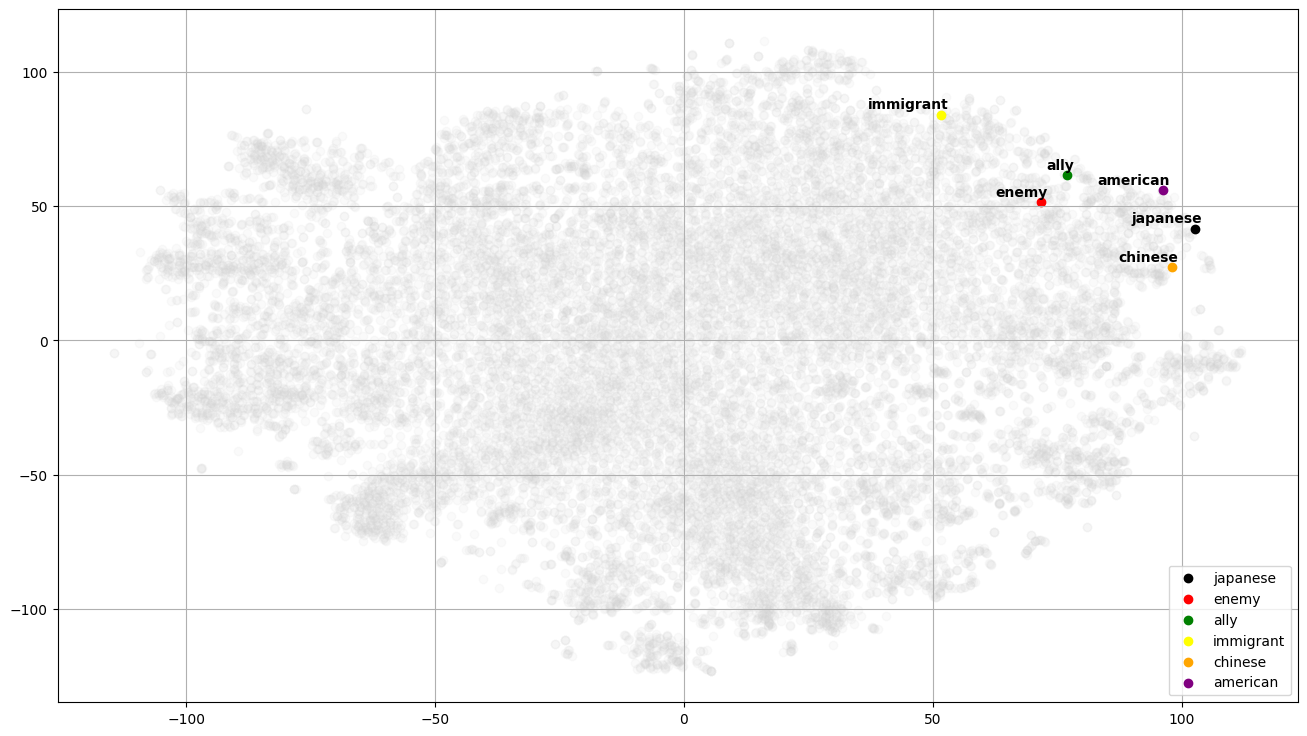

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline



word_list = model.wv.index_to_key
words = []
embeddings = []

for word in word_list:
    embeddings.append(model.wv[word])
    words.append(word)

embeddings_array = np.array(embeddings)

tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_2d.fit_transform(embeddings_array)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    
    # Create a color map for the selected words
    colors = ['black', 'red', 'green', 'yellow', 'orange', 'purple']
    selected_words = ['japanese', 'enemy', 'ally', 'immigrant', 'chinese', 'american']
    
    # Scatter plot for all words
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, color='lightgray', alpha=a)  # Use a neutral color for other words

    # Scatter and annotate selected words
    for word, color in zip(selected_words, colors):
        index = words.index(word)
        plt.scatter(embeddings[index, 0], embeddings[index, 1], color=color, alpha=1, label=word)
        plt.annotate(word, xy=(embeddings[index, 0], embeddings[index, 1]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10, weight='bold')

    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_2d('1924 WORD EMBEDDINGS', embeddings_2d, words, a=0.1)


## Sentiment Score

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hahm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
def filter_sentences(df, keyword):
    # Filter sentences containing the keyword
    return df[df['processed_text'].str.contains(keyword, case=False)]

def analyze_sentiment(sentences):
    # Analyze sentiment of each sentence
    sentiment_scores = [sia.polarity_scores(sentence) for sentence in sentences]
    return sentiment_scores

# Filter sentences
japanese_sentences = filter_sentences(df, 'japanese')

# Analyze sentiment
japanese_sentiment = analyze_sentiment(japanese_sentences['processed_text'])

# Summing up all the compound scores
j_total_compound_score = sum([sentiment['compound'] for sentiment in japanese_sentiment])

# Calculating the average compound score
j_average_compound_score = j_total_compound_score / len(japanese_sentiment)

print(j_average_compound_score)

0.6427343476018604


## Update the CSV file

In [19]:
# Data to be added as a new row
new_data = {
    'year': [year],
    'enemy': [enemy],
    'immigrant': [immigrant],
    'soldier': [soldier],
    'ally': [ally],
    'american': [american],
    'chinese': [chinese],
    'j_average_compound_score': [j_average_compound_score]
}

# File path
file_path = 'cosine.csv'
new_row = pd.DataFrame(new_data)

# Check if the file exists
try:
    # Read the existing CSV file
    df_results = pd.read_csv(file_path)
except FileNotFoundError:
    # If file does not exist, create a new DataFrame
    df_results = pd.DataFrame(columns=new_data.keys())

# Append the new data
df_results= pd.concat([df_results, new_row], ignore_index=True)

# Save the updated DataFrame to CSV
df_results.to_csv(file_path, index=False)

# Display the updated DataFrame
df_results


,year,enemy,immigrant,soldier,ally,american,chinese,j_average_compound_score
0,1917,-0.069088,0.507748,0.058896,0.053292,0.242649,0.517685,0.716156
1,1918,0.027670,0.293286,-0.102258,0.111673,0.241416,0.667243,0.435222
2,1919,0.075328,0.458734,0.176309,-0.041869,0.297431,0.528501,0.627945
3,1920,0.134512,0.502782,0.143171,0.053065,0.225031,0.470205,0.624098
4,1921,0.094014,0.392006,0.073137,-0.002816,0.306282,0.424202,0.713038
5,1922,0.007384,0.162523,0.040070,0.087442,0.172594,0.376771,0.727726
6,1923,0.064556,0.408621,0.094039,-0.008350,0.245259,0.599330,0.627035
7,1924,0.102849,0.623948,0.015290,-0.027155,0.375301,0.545300,0.642734
